<div style="display:block;width:100%;margin:auto;" direction=rtl align=center><br><br>
    <div  style="width:100%;margin:100;display:block;background-color:#fff0;"  display=block align=center>
        <table style="border-style:hidden;border-collapse:collapse;">
            <tr>
                <td  style="border: none!important;">
                    <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="skyblue">University of Tehran</i></font></h1>
                </td>
                <td style="border: none!important;">
                    <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
                </td>
            </tr>
        </table>
    </div>
</div>

## Information Bottleneck Methods: IB and DIB Algorithms

$
\textbf{Libraries and Functions: }
$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
def kl_divergence(p, q):
    p = np.clip(p, 1e-12, None)
    q = np.clip(q, 1e-12, None)
    return np.sum(p * np.log(p / q))

def entropy(p):
    p = np.clip(p, 1e-12, None)
    return -np.sum(p * np.log(p))

def mutual_information(px_y):
    px = np.sum(px_y, axis=1)
    py = np.sum(px_y, axis=0)
    px_y_product = np.outer(px, py)
    return kl_divergence(px_y.flatten(), px_y_product.flatten())

$
\textbf{Algorithm 1 - The information bottleneck (IB) method: } \\
\textbf{} \\
\textbf{Given: } p(x, y), \beta \geq 0 \\
\textbf{Initialize: } q^{(0)}(t \mid x) \\
\textbf{} q^{(0)}(t) = \sum_x p(x) q^{(0)}(t \mid x) \\
\textbf{} q^{(0)}(y \mid t) = \frac{1}{q^{(0)}(t)} \sum_x p(x, y) q^{(0)}(t \mid x) \\
\textbf{} n = 0 \\
\textbf{While not converged do} \\
\quad \textbf{} n = n + 1 \\
\quad \textbf{} q^{(n)}(t \mid x) = \frac{q^{(n-1)}(t)}{Z(x, \beta)} \exp\left(-\beta D_{\text{KL}}[p(y \mid x) \| q^{(n-1)}(y \mid t)]\right) \\
\quad \textbf{} q^{(n)}(t) = \sum_x p(x) q^{(n)}(t \mid x) \\
\quad \textbf{} q^{(n)}(y \mid t) = \frac{1}{q^{(n)}(t)} \sum_x q^{(n)}(t \mid x) p(x, y) \\
\textbf{End while} \\
$

In [ ]:
def information_bottleneck(px_y, beta, num_clusters, limit_iter=10, max_iter=10000, tolerance=1e-6, verbose=1):
    px = np.sum(px_y, axis=1)
    py = np.sum(px_y, axis=0)
    qt_if_x = np.random.rand(num_clusters, px_y.shape[0])
    qt_if_x /= np.sum(qt_if_x, axis=0, keepdims=True)
    qt = np.dot(qt_if_x, px)
    qy_if_t = np.dot(px_y.T, qt_if_x.T) / qt

    for iteration in range(max_iter):

        dkl_values = np.zeros((px_y.shape[0], num_clusters))
        for t in range(num_clusters):
            for x in range(px_y.shape[0]):
                dkl_values[x, t] = kl_divergence(px_y[x, :] / px[x], qy_if_t[:, t])

        new_qt_if_x = np.exp(-beta * dkl_values.T) * qt[:, np.newaxis]
        new_qt_if_x /= np.sum(new_qt_if_x, axis=0, keepdims=True)

        if ((np.linalg.norm(new_qt_if_x - qt_if_x) <= tolerance) and (iteration >= limit_iter)):
            green_text = "\033[32m"
            reset_text = "\033[0m"
            if(verbose==1):
                print(f"{green_text}Converged after {iteration} iterations.{reset_text}")
            break

        qt_if_x = new_qt_if_x
        qt = np.dot(qt_if_x, px)
        qy_if_t = np.dot(px_y.T, qt_if_x.T) / qt

    else:
        red_text = "\033[31m"
        reset_text = "\033[0m"
        print(f"{red_text}Did not converge within {max_iter} iterations.{reset_text}")

    return qt_if_x, qt, qy_if_t

In [ ]:
px_y = np.random.uniform(0, 1, size=(2, 2))
px_y /= px_y.sum()
print("px_y: \n", px_y)
print("--------------------------------------------------------------")

beta = 0
num_clusters = 3

qt_if_x, qt, qy_if_t = information_bottleneck(px_y, beta, num_clusters)

print("--------------------------------------------------------------")
print("q(t|x): \n", qt_if_x)
print("--------------------------------------------------------------")
print("q(t): \n", qt)
print("--------------------------------------------------------------")
print("q(y|t): \n", qy_if_t)
print("--------------------------------------------------------------")

px_y: 
 [[0.31516537 0.22995196]
 [0.1600234  0.29485927]]
--------------------------------------------------------------
Converged after 10 iterations.
--------------------------------------------------------------
q(t|x): 
 [[0.36055933 0.36055933]
 [0.36325774 0.36325774]
 [0.27618294 0.27618294]]
--------------------------------------------------------------
q(t): 
 [0.36055933 0.36325774 0.27618294]
--------------------------------------------------------------
q(y|t): 
 [[0.47518877 0.47518877 0.47518877]
 [0.52481123 0.52481123 0.52481123]]
--------------------------------------------------------------


In [ ]:
def compute_ib_scatter(px_y, beta_values, num_clusters, limit_iter=10, max_iter=10000, tolerance=1e-6):
    I_X_T_values = []
    I_T_Y_values = []

    px = np.sum(px_y, axis=1)

    for beta in tqdm(beta_values, desc="Processing Beta Values"):
        qt_if_x, qt, qy_if_t = information_bottleneck(
            px_y, beta, num_clusters, limit_iter, max_iter, tolerance, 0)

        qt_x = qt_if_x * px
        I_X_T = mutual_information(qt_x)
        qy_t = qy_if_t * qt
        I_T_Y = mutual_information(qy_t)

        I_X_T_values.append(I_X_T)
        I_T_Y_values.append(I_T_Y)

    return np.array(I_X_T_values), np.array(I_T_Y_values)

Processing Beta Values: 100%|██████████| 1000/1000 [00:06<00:00, 149.15it/s]


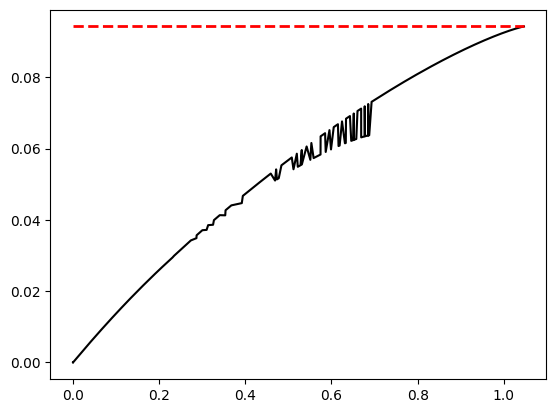

In [ ]:
px_y = np.random.uniform(0, 1, size=(3, 4))
px_y /= px_y.sum()
I_X_Y = mutual_information(px_y)

beta_values = np.linspace(0, 100, 1000)
num_clusters = 3

I_X_T_values, I_T_Y_values = compute_ib_scatter(px_y, beta_values, num_clusters)

sorted_indices = np.argsort(I_X_T_values)

plt.plot(I_X_T_values[sorted_indices], I_T_Y_values[sorted_indices], color='black')
plt.plot([I_X_T_values.min(), I_X_T_values.max()],
        [I_X_Y, I_X_Y], color='red', linestyle='--', linewidth=2)

$
\textbf{Algorithm 2 - The deterministic information bottleneck (DIB) method:} \\
\textbf{} \\
\textbf{Given: } p(x, y), \beta \geq 0 \\
\textbf{Initialize } f^{(0)}(x) \\
\textbf{Set } q^{(0)}(t) = \sum_{x : f^{(0)}(x) = t} p(x) \\
\textbf{Set } q^{(0)}(y \mid t) = \frac{\sum_{x : f^{(0)}(x) = t} p(x, y)}{\sum_{x : f^{(0)}(x) = t} p(x)} \\
\textbf{} n = 0 \\
\textbf{While not converged do} \\
\quad \textbf{} n = n + 1 \\
\quad \textbf{} d^{(n-1)}(x, t) = D_{\text{KL}} \left[ p(y \mid x) \| q^{(n-1)}(y \mid t) \right] \\
\quad \textbf{} \ell^{(n-1)}_\beta(x, t) = \log q(t) - \beta d^{(n-1)}(x, t) \\
\quad \textbf{} f^{(n)}(x) = \arg\max_t \ell^{(n-1)}_\beta(x, t) \\
\quad \textbf{} q^{(n)}(t) = \sum_{x : f^{(n)}(x) = t} p(x) \\
\quad \textbf{} q^{(n)}(y \mid t) = \frac{\sum_{x : f^{(n)}(x) = t} p(x, y)}{\sum_{x : f^{(n)}(x) = t} p(x)} \\
\textbf{End while} \\
$


In [ ]:
def deterministic_information_bottleneck(px_y, beta, num_clusters, limit_iter=10, max_iter=10000, verbose=1):
    px = np.sum(px_y, axis=1)
    py = np.sum(px_y, axis=0)
    fx = np.random.randint(0,num_clusters,size=px_y.shape[0])

    qt = np.zeros(num_clusters)
    for t in range(num_clusters):
        qt[t] = np.sum(px[fx==t])

    qy_if_t = np.zeros((px_y.shape[1],num_clusters))
    for t in range(num_clusters):
        if qt[t] == 0:
            continue
        qy_if_t[:, t] = np.sum(px_y[fx == t,:],axis=0) / qt[t]

    for iteration in range(max_iter):
        dkl_values = np.zeros((px_y.shape[0], num_clusters))
        lbeta_values = np.zeros((px_y.shape[0], num_clusters))
        for t in range(num_clusters):
            if (qt[t] == 0):
                continue
            for x in range(px_y.shape[0]):
                dkl_values[x, t] = kl_divergence(px_y[x, :] / px[x], qy_if_t[:, t])
                lbeta_values[x, t] = np.log(qt[t]) - beta * dkl_values[x, t]

        new_fx = np.argmax(lbeta_values, axis=1)

        if (np.all(new_fx == fx) and (iteration >= limit_iter)):
            green_text = "\033[32m"
            reset_text = "\033[0m"
            if(verbose==1):
                print(f"{green_text}Converged after {iteration} iterations.{reset_text}")
            break

        fx = new_fx

        qt = np.zeros(num_clusters)
        for t in range(num_clusters):
            qt[t] = np.sum(px[fx == t])

        qy_if_t = np.zeros((px_y.shape[1],num_clusters))
        for t in range(num_clusters):
            if qt[t] == 0:
                continue
            qy_if_t[:, t] = np.sum(px_y[fx == t,:],axis=0) / qt[t]

    else:
        red_text = "\033[31m"
        reset_text = "\033[0m"
        print(f"{red_text}Did not converge within {max_iter} iterations.{reset_text}")

    return fx, qt, qy_if_t

In [ ]:
px_y = np.random.uniform(0, 1, size=(3, 4))
px_y /= px_y.sum()
print("px_y: \n", px_y)
print("--------------------------------------------------------------")

beta = 0
num_clusters = 3

fx, qt, qy_if_t = deterministic_information_bottleneck(px_y, beta, num_clusters)

print("--------------------------------------------------------------")
print("f(x): \n", fx)
print("--------------------------------------------------------------")
print("q(t): \n", qt)
print("--------------------------------------------------------------")
print("q(y|t): \n", qy_if_t)
print("--------------------------------------------------------------")

px_y: 
 [[0.07121025 0.03226959 0.09592668 0.00307234]
 [0.06079856 0.12094485 0.18445827 0.13613314]
 [0.10257882 0.08412805 0.08766761 0.02081184]]
--------------------------------------------------------------
Converged after 10 iterations.
--------------------------------------------------------------
f(x): 
 [0 0 0]
--------------------------------------------------------------
q(t): 
 [1. 0. 0.]
--------------------------------------------------------------
q(y|t): 
 [[0.23458763 0.         0.        ]
 [0.23734249 0.         0.        ]
 [0.36805256 0.         0.        ]
 [0.16001732 0.         0.        ]]
--------------------------------------------------------------
